<a href="https://colab.research.google.com/github/samik1986/3D_Developing_brain/blob/main/MEDIAR_(model1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEDIAR Prediction Tutorial

This tutorial guides how to conduct prediction using pretrained models with MEDIAR pipeline. Note that this is a inline version of running `predict.py` in MEDIAR repo.



---


## 1. Setup

Clone Github repository and install dependencies.

In [1]:
# Clone MEDIAR github repo
!git clone https://github.com/Lee-Gihun/MEDIAR.git
%rm -rf ./sample_data
%cd MEDIAR

# # Install dependencies
%pip install -r requirements.txt
%pip install segmentation-models-pytorch==0.3.1
%pip install wandb
!wandb off

fatal: destination path 'MEDIAR' already exists and is not an empty directory.
/content/MEDIAR
  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata (30 kB)
  Using cached timm-0.9.2-py3-none-any.whl.metadata (68 kB)
Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Attempting uninstall: timm
    Found existing installation: timm 0.4.12
    Uninstalling timm-0.4.12:
      Successfully uninstalled timm-0.4.12
  Attempting uninstall: segmentation_models_pytorch
    Found existing installation: segmentation-models-pytorch 0.3.1
    Uninstalling segmentation-models-pytorch-0.3.1:
      Successfully uninstalled segmentation-models-pytorch-0.3.1
  Using cached segmentation_models_pytorch-0.3.1-py3-none-any.whl.metadata (29 kB)
  Using cached timm-0.4.12-py3-none-any.whl.metadata (30 kB)
Using cached segmentation_models_pytorch-0.3.1-py3-none-any.whl (102 kB)
Using cached timm-0.4.12-py3-none-any.w



---


### 2. Prepare MEDIAR Models

MEDIAR uses two pretrained models to conduct ensemble prediction.

- Model1 : fine-tuned from "Phase 1" pretraining.
- Model2 : fine-tuned from "Phase 2" pretraining.

for the details on how each model is trained, [please refer to our Paper](https://arxiv.org/abs/2212.03465).


In [3]:
# Download MEDIAR pretrained weights
%mkdir weights
!gdown https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L -O weights/from_phase1.pth
!gdown https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx -O weights/from_phase2.pth

model_path1 = "./weights/from_phase1.pth"
model_path2 = "./weights/from_phase2.pth"

import torch
weights1 = torch.load(model_path1, map_location="cpu")
weights2 = torch.load(model_path2, map_location="cpu")

mkdir: cannot create directory ‘weights’: File exists
Downloading...
From (original): https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L
From (redirected): https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L&confirm=t&uuid=1c8e559e-ed7c-4b0c-b94f-983f429f396c
To: /content/MEDIAR/weights/from_phase1.pth
100% 486M/486M [00:07<00:00, 68.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx
From (redirected): https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx&confirm=t&uuid=70554e35-e328-4732-9881-401e8729dfd0
To: /content/MEDIAR/weights/from_phase2.pth
100% 486M/486M [00:04<00:00, 103MB/s]


In [4]:
!mkdir -p weights/pretrained
!gdown https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L -O weights/pretrained/phase1.pth
!gdown https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx -O weights/pretrained/phase2.pth

Downloading...
From (original): https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L
From (redirected): https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L&confirm=t&uuid=438b5b85-0214-42f1-8a91-85bf1b79f833
To: /content/MEDIAR/weights/pretrained/phase1.pth
100% 486M/486M [00:07<00:00, 65.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx
From (redirected): https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx&confirm=t&uuid=36dad27e-b6a7-46ad-b55f-e47ad27c27e6
To: /content/MEDIAR/weights/pretrained/phase2.pth
100% 486M/486M [00:03<00:00, 125MB/s]


In [5]:
%mkdir -p /content/MEDIAR/weights/pretrained
%mv /content/weights/pretrained/phase1.pth /content/MEDIAR/weights/pretrained/phase1.pth

mv: cannot stat '/content/weights/pretrained/phase1.pth': No such file or directory


We load weights on the our `MEDIARFormer` model.

`MEDIARFormer` predicts 3-dimensional outputs (3 classes), where each corresponds to:

- `Cell Recognition`: Predicts whether a pixel belongs to `cell (1)` or `background (0)`
- `Cell Distinction`: Horizontal Vector & Vertical Vector to the cell center.

In [6]:
import torch
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np

from train_tools import *
from train_tools.models import MEDIARFormer
from core.MEDIAR import Predictor, EnsemblePredictor

model_args = {
    "classes": 3,
    "decoder_channels": [1024, 512, 256, 128, 64],
    "decoder_pab_channels": 256,
    "encoder_name": 'mit_b5',
    "in_channels": 3
}

model1 = MEDIARFormer(**model_args)
model1.load_state_dict(weights1, strict=False)

model2 = MEDIARFormer(**model_args)
model2.load_state_dict(weights2, strict=False)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b5.pth" to /root/.cache/torch/hub/checkpoints/mit_b5.pth
100%|██████████| 313M/313M [00:01<00:00, 169MB/s]


<All keys matched successfully>

In [7]:
import torch
print(torch.cuda.device_count())      # How many GPUs available?
print(torch.cuda.get_device_name(0))  # Name of the first GPU (if any)

1
Tesla T4


Train

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!rm train_tools/data_utils/mapping_labeled.json
!rm train_tools/data_utils/mapping_tuning.json
!rm train_tools/data_utils/mapping_public.json

import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]

images_raw = sorted(glob.glob(image_path), key=natural_sort_key)
labels_raw = sorted(glob.glob(label_path), key=natural_sort_key)


In [20]:
!python ./generate_mapping.py --root=/content/drive/MyDrive/CSHL/FB_paper


----------- Path Mapping for Labeled Data is Started... -----------


----------- Path Mapping for Tuning Data is Started... -----------


----------- Path Mapping for Public Data is Started... -----------


-------------- Path Mapping is Ended !!! ---------------------------



In [15]:
!pip install imagecodecs

In [16]:
import torch
torch.cuda.empty_cache()

In [ ]:
!python ./main.py --config_path=/content/MEDIAR/config/step2_finetuning/finetuning1.json

2025-08-07 14:31:02.698003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754577062.718441   10776 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754577062.725229   10776 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754577062.752045   10776 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754577062.752087   10776 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754577062.752095   10776 computation_placer.cc:177] computation placer alr



---



### 3. Prepare Microscopy Data

We prepared 2 microscopy images in the `./input_path` directory. Let's see the images.

In [ ]:
input_path = "./image/examples"

img1 = io.imread(f"{input_path}/img1.tiff") #
io.imshow(img1)

NameError: name 'io' is not defined

In [ ]:
# img2 = io.imread(f"{input_path}/cell3.png") #
# io.imshow(img2)

In [ ]:
# img3 = io.imread(f"{input_path}/brain cells.png") #
# io.imshow(img3)

# 새 섹션



---



### 4. Prediction - (1): Single Model

Let's detect the cell instances in the image using a single `MEDIARFormer` model.

- The `Predictor` conduct its pediction on all images in the `input_path` and save the results in the `output_path`.

- In this example, we do not use test-time Augmentation by setting `use_tta` as `False`.

In [ ]:
output_path = "results"

predictor = Predictor(model1, "cuda:0", input_path, output_path, algo_params={"use_tta": False})
_ = predictor.conduct_prediction()

Prediction finished: img1.tiff; img size = torch.Size([1, 3, 480, 640]); costing: 1.23s
Prediction finished: img2.tif; img size = torch.Size([1, 3, 2048, 2048]); costing: 12.43s

 Total Time Cost: 13.65s


The results are as follows:

/tmp/ipython-input-20-4063708419.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(pred1, cmap="cividis")
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)



36 Cells detected!


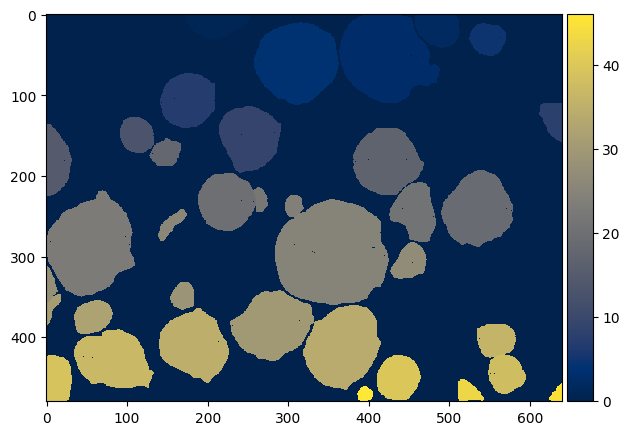

In [ ]:
pred1 = io.imread(f"./{output_path}/img1_label.tiff")
io.imshow(pred1, cmap="cividis")

cell_count = len(np.unique(pred1))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import label2rgb
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

# Define folders
image_folder = "/content/MEDIAR/data/Official/Tuning/images"
gt_folder = "/content/MEDIAR/data/Official/Tuning/labels"
pred_folder = "/content/MEDIAR/results"

# Helper to match predicted labels to ground truth using Hungarian algorithm
def match_labels(gt, pred):
    gt_labels = np.unique(gt)
    pred_labels = np.unique(pred)

    gt_labels = gt_labels[gt_labels != 0]
    pred_labels = pred_labels[pred_labels != 0]

    cost_matrix = np.zeros((len(gt_labels), len(pred_labels)))

    for i, g in enumerate(gt_labels):
        g_mask = gt == g
        for j, p in enumerate(pred_labels):
            p_mask = pred == p
            intersection = np.logical_and(g_mask, p_mask).sum()
            union = np.logical_or(g_mask, p_mask).sum()
            iou = intersection / union if union != 0 else 0
            cost_matrix[i, j] = -iou  # Negative for maximization

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    mapping = {}
    for r, c in zip(row_ind, col_ind):
        if -cost_matrix[r, c] > 0.1:  # Threshold to ignore bad matches
            mapping[pred_labels[c]] = gt_labels[r]

    matched_pred = np.zeros_like(pred)
    for pl, gl in mapping.items():
        matched_pred[pred == pl] = gl

    return matched_pred

# Compute confusion for foreground/background
def compute_confusion(y_true, y_pred):
    binary_true = y_true > 0
    binary_pred = y_pred > 0

    tp = np.logical_and(binary_true, binary_pred).sum()
    tn = np.logical_and(~binary_true, ~binary_pred).sum()
    fp = np.logical_and(~binary_true, binary_pred).sum()
    fn = np.logical_and(binary_true, ~binary_pred).sum()

    total = tp + tn + fp + fn
    return {
        "TP": tp / total,
        "FP": fp / total,
        "FN": fn / total,
        "TN": tn / total
    }

# Store all metrics
all_confusions = []
all_precisions, all_recalls, all_f1s, all_accuracies = [], [], [], []

# Find matching files
files = sorted([f for f in os.listdir(image_folder) if f.endswith('.tiff')])

# Plotting
fig, axs = plt.subplots(len(files), 3, figsize=(12, 4 * len(files)))

for idx, fname in enumerate(files):
    image_path = os.path.join(image_folder, fname)
    gt_path = os.path.join(gt_folder, fname.replace('.tiff', '_label.tiff'))
    pred_path = os.path.join(pred_folder, fname.replace('.tiff', '_label.tiff'))

    img = imread(image_path)
    gt = imread(gt_path)
    pred = imread(pred_path)

    pred_matched = match_labels(gt, pred)

    # Compute confusion
    confusion = compute_confusion(gt, pred_matched)
    all_confusions.append(confusion)

    # Flatten for metric calculation
    y_true = (gt > 0).flatten().astype(int)
    y_pred = (pred_matched > 0).flatten().astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_accuracies.append(acc)

    # Plot
    axs[idx, 0].imshow(img, cmap='gray')
    axs[idx, 0].set_title(f"Original - {fname}")
    axs[idx, 0].axis('off')

    axs[idx, 1].imshow(label2rgb(pred_matched, image=img, bg_label=0))
    axs[idx, 1].set_title("Predicted Mask")
    axs[idx, 1].axis('off')

    axs[idx, 2].imshow(label2rgb(gt, image=img, bg_label=0))
    axs[idx, 2].set_title("Ground Truth Mask")
    axs[idx, 2].axis('off')

plt.tight_layout()
plt.show()

# ---- Plot averaged confusion matrix ----
avg_conf = {
    k: np.mean([conf[k] for conf in all_confusions])
    for k in ['TP', 'FP', 'FN', 'TN']
}

conf_matrix = np.array([
    [avg_conf['TP'], avg_conf['FP']],
    [avg_conf['FN'], avg_conf['TN']]
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=['Pred: Obj', 'Pred: Bkg'], yticklabels=['True: Obj', 'True: Bkg'], fmt=".2f")
plt.title("Average Confusion Matrix (Fraction)")
plt.show()

# ---- Print average metrics ----
print(f"Average Precision: {np.mean(all_precisions):.4f}")
print(f"Average Recall: {np.mean(all_recalls):.4f}")
print(f"Average F1 Score: {np.mean(all_f1s):.4f}")
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")


In [ ]:
# pred2 = io.imread(f"./{output_path}/brain cells_label.tiff")
# io.imshow(pred2, cmap="cividis")

# cell_count = len(np.unique(pred2))-1 # exclude the background
# print(f"\n{cell_count} Cells detected!")

In [ ]:
pred2 = io.imread(f"./{output_path}/cell3_label.tiff")
io.imshow(pred2, cmap="cividis")

cell_count = len(np.unique(pred2))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")



---



### 5. Prediction - (2): Ensemble Model + TTA

Let's use the ensemble models with TTA.

- In this example, we use test-time Augmentation by setting `use_tta` as `True`.

It takes much longer, as it need to conduct multiple forward paths.

In [ ]:
predictor = EnsemblePredictor(model1, model2, "cuda:0", input_path, output_path, algo_params={"use_tta": True})
_ = predictor.conduct_prediction()

In [ ]:
pred1 = io.imread(f"./{output_path}/img1_label.tiff")
io.imshow(pred1, cmap="cividis")

cell_count = len(np.unique(pred1))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")

In [ ]:
pred2 = io.imread(f"./{output_path}/img2_label.tiff")
io.imshow(pred2, cmap="cividis")

cell_count = len(np.unique(pred2))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")